In [0]:
!wget http://memorability.csail.mit.edu/lamem.tar.gz

--2019-12-18 04:56:18--  http://memorability.csail.mit.edu/lamem.tar.gz
Resolving memorability.csail.mit.edu (memorability.csail.mit.edu)... 128.30.195.49
Connecting to memorability.csail.mit.edu (memorability.csail.mit.edu)|128.30.195.49|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2708368436 (2.5G) [application/x-gzip]
Saving to: ‘lamem.tar.gz’

lamem.tar.gz        100%[===================>]   2.52G  12.7MB/s    in 3m 27s  

2019-12-18 04:59:47 (12.5 MB/s) - ‘lamem.tar.gz’ saved [2708368436/2708368436]



In [0]:
!tar -xf /content/lamem.tar.gz

In [0]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io,transform
import torch
from tqdm import tqdm
import os
import time
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, utils,models
import copy
from skimage import io, transform
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [0]:
dataset_train=pd.read_csv("/content/drive/My Drive/image memorability/dataset/train_dataset.csv")
dataset_validation = pd.read_csv("/content/drive/My Drive/image memorability/dataset/validation_dataset.csv")

In [0]:
model_50 = models.resnet50(pretrained=True) 


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 198MB/s]


In [0]:
model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
  param.requires_grad = False
import torch.nn as nn

n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)



1


In [0]:
weights_dict= torch.load("/content/drive/My Drive/image memorability/bestmodel50.pt")

In [0]:
model_50.load_state_dict(weights_dict["model_state_dict"])


<All keys matched successfully>

In [0]:

model_50=model_50.to(device)

In [0]:
model_50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:

class AsetheticsDataset(Dataset):
  '''asethitics dataset'''
  def __init__(self,dataframe,root_dir,transform=None):
    """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
    """
    self.data = dataframe
#     self.data.rename(columns=columns,inplace=True)
#     self.data.drop(self.data.columns[[1,2,3,4,5,6,8,9]] , axis=1,inplace=True)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
   
    if torch.is_tensor(idx):
      idx = idx.tolist()
   
    image_name =  os.path.join(self.root_dir,self.data.iloc[idx,0])
    image = io.imread(image_name)
    mem_val = self.data.iloc[idx,1]
#     return_sample={}
    return_sample = {
          'image':image,
          'memorability_score':mem_val 
    }
    if self.transform:
      return_sample = self.transform(return_sample)

     
    return return_sample

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        
        image,mem_val = sample['image'], sample["memorability_score"]
        
        h, w = image.shape[:2]
        
        # if isinstance(self.output_size, int):
        #     if h > w:
        #         new_h, new_w = self.output_size * h / w, self.output_size
        #     else:
        #         new_h, new_w = self.output_size, self.output_size * w / h
        # else:
        #     new_h, new_w = self.output_size

        # new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (self.output_size,self.output_size,3))
        return {'image': img, 'memorability_score': mem_val}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        
        image, mem_val = sample['image'], sample['memorability_score']
#         print(type(torch.from_numpy(image)))
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
#         print(image.shape)
      
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'memorability_score': mem_val}
class Normalize(object):
  def __init__(self,mean,std):
    self.mean=mean
    self.std=std
  def __call__(self,sample):
    image, mem_val = sample["image"], sample["memorability_score"]
    normalized=  (image -self.mean) / self.std
    return {
        "image":normalized,
        "memorability_score" : mem_val
    }

In [0]:

transformed_dataset_train = AsetheticsDataset(dataset_train,root_dir="/content/lamem/images",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

transformed_dataset_val= AsetheticsDataset(dataset_validation,root_dir="/content/lamem/images",
                                        transform=transforms.Compose([Rescale(224),ToTensor(),Normalize(0.5,0.5)
                                                          ]))

In [0]:

train_dataloader=DataLoader(transformed_dataset_train,batch_size=32,shuffle=True)
validation_dataloader=DataLoader(transformed_dataset_val,batch_size=32,shuffle=True)

In [0]:
dataset_validation["X"][dataset_validation["y"]<0.5]

6        00027418.jpg
53       00014014.jpg
60       00036279.jpg
63       00058240.jpg
91       00025576.jpg
             ...     
11657    00024858.jpg
11680    00002023.jpg
11696    00038020.jpg
11723    00027773.jpg
11743    00035915.jpg
Name: X, Length: 360, dtype: object

1172
/content/lamem/images/00015757.jpg


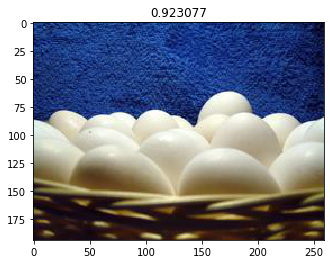

In [0]:
file=""#
def show_sample_from_dataset(i=0):
  global file#
  print(i)
  def show_image(image,asethics_value=0):
    plt.imshow(image)
    plt.title(str(asethics_value))

  image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
  file=image_path
  mem_val = os.path.join(str(dataset_validation.iloc[i]["y"]))
  print(file)
  show_image(io.imread(image_path),mem_val)

show_sample_from_dataset(1172)

In [0]:
file

'/content/lamem/images/00014014.jpg'

In [0]:
from PIL import Image
image=None
def image_loader(loader, image_name):
    global image
    
    image = Image.open(image_name).convert("RGB")
    #print(type(image))
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    if image.shape[1]==2:
        print(image.shape)
        return image.repeat((1,3,1,1))
    return image
data_transforms = transforms.Compose([
    
    transforms.Resize((224,224)),
 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print( (model_50(image_loader(data_transforms,file).float().to(device)).cpu().item()))

0.9251726269721985


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [0]:

def show_grid(n_row,n_col):
 
  i=1172
  _ ,fig = plt.subplots(n_row, n_col, figsize=(20,20))
#   print(fig)
  fig = fig.flatten()
#   print(fig)
  for f in fig:
#     print(i,f)
    image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
    mem_val = os.path.join(str(dataset_validation.iloc[i]["y"]))
    pred=model_50(image_loader(data_transforms,image_path).float().to(device)).cpu().item()
    
    f.imshow(io.imread(image_path))
    plt.tight_layout()
    f.title.set_text("real : "+ str(mem_val)+"\n predicted : "+str(pred))
    f.title.set_size(20)
#     f.title(str(aseth_value))
    i=i+1
show_grid(5,4)

In [0]:
from PIL import Image

from io import BytesIO

model  = model_50
finalconv_name="layer4"
params = list(model.parameters())
linear_layer_weights = np.squeeze(params[-3].cpu().data.numpy())
del params

def hook_feature(module, input, output):
    global feature
    feature = output.cpu().data.numpy()
model._modules.get(finalconv_name).register_forward_hook(hook_feature)


In [0]:
def regression_activation_mapping(image_tensor,feature,weights,file_path):
    '''
    Args :
    image_tensor : image tensor with size of (1,3,224,224)
    feature     : feature tensor  with  size of (1,2048,7,7)
    weights     : weights with size of (2048,)
    Returns :
    Regression activation map with size of (3,224,224)
    '''

    original_image =np.array( Image.open(file_path).convert("RGB"))
    size_upsample = (224, 224)
    height,width,_ = original_image.shape
    bz, nc, h, w = feature.shape
    cam = np.dot(weights.reshape(1,-1),feature.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    up_sampled_image =cv2.resize(cam_img, size_upsample) 
    heatmap = cv2.applyColorMap(cv2.resize(up_sampled_image,(width,height)),cv2.COLORMAP_JET)
    result =0.3*heatmap + 0.6*original_image
    return result
    

0.6578001379966736


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


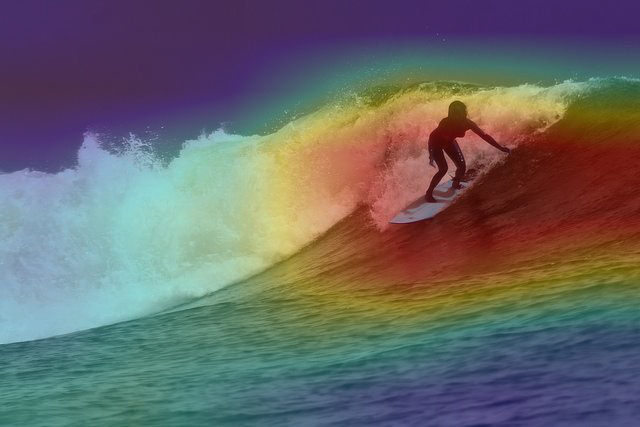

In [0]:
i=138
image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
tensor = image_loader(data_transforms,image_path).float()
print( (model_50(image_loader(data_transforms,image_path).float().to(device)).cpu().item()))
# model = image
a=regression_activation_mapping(tensor,feature,linear_layer_weights,image_path)
cv2.imwrite('CAM.jpg', a)
img = Image.open("./CAM.jpg")
img

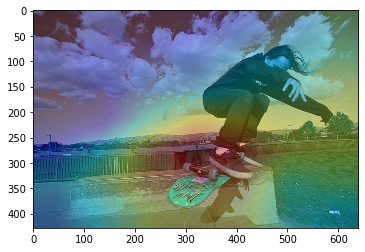

In [0]:
plt.imshow(img)

In [0]:

for i in range(0,len(dataset_validation)):
  image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
  tensor = image_loader(data_transforms,image_path).float()

  print(model_50(image_loader(data_transforms,image_path).float().to(device)).cpu().item())
  a=regression_activation_mapping(tensor,feature,linear_layer_weights,image_path)
  cv2.imwrite('./images/image'+str(i)+'.jpg', a)
  #img = Image.open("./images/CAM.jpg")
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


0.7282713055610657
0.8470911383628845
0.7233567237854004
0.9386774301528931
0.8773229122161865
0.6672073602676392
0.7421207427978516
0.7250704765319824
0.8562116026878357
0.7489840388298035
0.7066158056259155
0.7339257597923279
0.645937979221344
0.7922728657722473
0.7613422274589539
0.6766790151596069
0.787483274936676
0.6695941686630249
0.8432320356369019
0.7385616302490234
0.5886349081993103
0.681223452091217
0.8585076332092285
0.5686503648757935
0.879006028175354
0.7206589579582214
0.8640487194061279
0.6829723119735718
0.6818671822547913
0.6564550399780273
0.597128689289093
0.734225869178772
0.6953863501548767
0.7175653576850891
0.5621225833892822
0.7668126821517944
0.6638467907905579
0.7721843123435974
0.8511784076690674
0.731678307056427
0.712418258190155
0.6212242245674133
0.7867339849472046
0.7064168453216553
0.7387074828147888
0.7624099254608154
0.7134051322937012
0.7849934697151184
0.7596971392631531
0.9077926874160767
0.7272501587867737
0.7087444067001343
0.6730924844741821
0

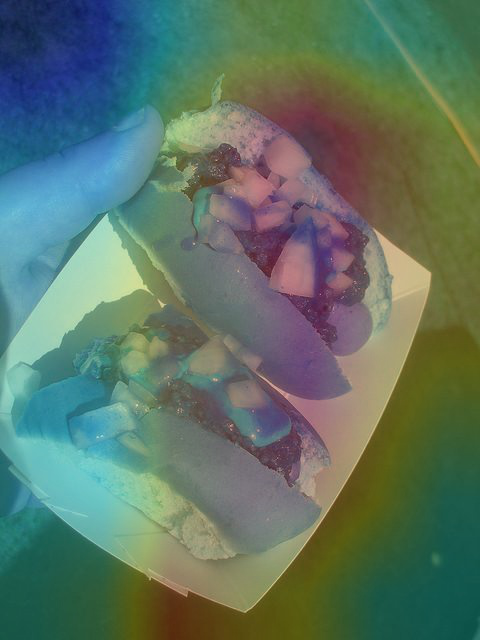

In [0]:
img = Image.open("./images/image11745.jpg")
img

In [0]:
def plot_tony(start_idx,end_idx):
  for i in range(start_idx,end_idx):
    f, axarr = plt.subplots(1,2,figsize=(7,7))
    img2 = Image.open("./images/image"+str(i)+".jpg")
    image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
    img1 = Image.open(image_path)
    axarr[0].imshow(img1)
    axarr[0].title.set_text("\n orignial image")
    axarr[1].imshow(img2)
    memscore = model_50(image_loader(data_transforms,image_path).float().to(device)).cpu().item()
  # print(memscore)
    axarr[1].title.set_text("memorability score : "+str(memscore))


In [0]:
plot_tony(0,100)

In [0]:
def plot_tony(start_idx,end_idx):
  for i in range(start_idx,end_idx):
    f, axarr = plt.subplots(1,2,figsize=(10,10))
    img2 = Image.open("./images/image"+str(i)+".jpg")
    image_path=os.path.join("/content/lamem/images/"+str(dataset_validation.iloc[i]["X"]))
    img1 = Image.open(image_path)
    axarr[0].imshow(img1)
    axarr[0].title.set_text("\n orignial image")
    axarr[1].imshow(img2)
    memscore = model_50(image_loader(data_transforms,image_path).float().to(device)).item()

    axarr[1].title.set_text("memorability score : "+str(memscore))

In [0]:
plot_tony(100,200)

In [0]:
plot_tony(200,300)

In [0]:
plot_tony(300,400)

In [0]:
plot_tony(400,500) 

In [0]:

plot_tony(500,600)

In [0]:
plot_tony(600,700)

In [0]:
plot_tony(700,800)

In [0]:
plot_tony(800,820)

In [0]:
plot_tony(820,900)

In [0]:
plot_tony(900,1000)

In [0]:
plot_tony(1000,1100)

In [0]:
plot_tony(1100,1200)

In [0]:
plot_tony(1200,1300)

In [0]:
plot_tony(1300,1400)

In [0]:
plot_tony(1400,1500)

In [0]:
plot_tony(1500,1600)

In [0]:
plot_tony(1600,1700)

In [0]:
plot_tony(1700,1800)

In [0]:
plot_tony(1800,1900)

In [0]:
plot_tony(1900,2000)

In [0]:
plot_tony(2000,2100)

In [0]:
plot_tony(2100,2200)

In [0]:
plot_tony(2200,2300)

In [0]:
plot_tony(2300,2400)

In [0]:
plot_tony(2400,2500)

In [0]:
plot_tony(2500,2600)

In [0]:
plot_tony(2600,2700)

In [0]:
plot_tony(2700,2800)

In [0]:
plot_tony(2800,2900)

In [0]:
plot_tony(2900,3000)